# Aviation Network Analysis: Global Flight Connectivity Study

## Project Overview

This notebook analyzes the global aviation network as a complex graph system, revealing patterns in how airports, airlines, and routes connect our world. Using real-world data from over 9,000 airports and 55,000 routes, we apply network science, graph theory, and geospatial analysis to understand the structure of global air travel.

## Key Questions We'll Answer

- Which airports serve as critical global hubs?
- How connected are different countries to the international network?
- What natural clusters or communities exist in the aviation system?
- How many flights separate any two airports?
- Which aircraft types dominate different route types?
- Where are the most extreme and isolated airports?

## Why This Matters

Understanding aviation networks helps us assess infrastructure resilience, predict travel patterns, identify market opportunities, and inform policy decisions about airline regulations and airport development. The hub-and-spoke model that dominates modern aviation creates a fascinating small-world network where most destinations are just 2-3 connections apart.

## Data Source
The core of the data comes from here: https://ourairports.com/data/

**1. Setup and Data Loading**

First, we import necessary libraries and load the datasets. We mainly use airline_routes.json for network analysis, but fall back to routes_new.dat for equipment (plane) data, as the JSON file does not contain plane types.

In [1]:
import pandas as pd
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore') # Clean up output

# --- 1. Load Data Functions ---
def load_data():
    # Load Airports (Handle 'NA' for North America correctly)
    airports = pd.read_csv('airports_new.csv', keep_default_na=False, na_values=[''])
    airports = airports.dropna(subset=['iata_code']).drop_duplicates(subset=['iata_code'])
    airports.set_index('iata_code', inplace=True)
    
    # Load Routes (JSON)
    with open('airline_routes.json', 'r') as f:
        routes_json = json.load(f)
        
    # Load Routes (CSV/DAT) for Equipment & Airline info
    route_cols = ['Airline', 'AirlineID', 'Source', 'SourceID', 'Dest', 'DestID', 'Codeshare', 'Stops', 'Equipment']
    routes_dat = pd.read_csv('routes_new.dat', header=None, names=route_cols)
    routes_dat['Source'] = routes_dat['Source'].astype(str)
    routes_dat['Dest'] = routes_dat['Dest'].astype(str)
    
    # Load Navaids
    navaids = pd.read_csv('navaids_new.csv')
    
    # Load Airlines
    airlines = pd.read_csv('airlines_new.dat', header=None, 
                           names=['AirlineID', 'Name', 'Alias', 'IATA', 'ICAO', 'Callsign', 'Country', 'Active'])
    airlines.set_index('IATA', inplace=True)
    
    return airports, routes_json, routes_dat, navaids, airlines

def build_graph(routes_json, airports_df):
    G = nx.DiGraph()
    valid_nodes = set(airports_df.index)
    
    for source, data in routes_json.items():
        if source in valid_nodes:
            for route in data.get('routes', []):
                target = route.get('iata')
                if target in valid_nodes:
                    G.add_edge(source, target, weight=route.get('km', 0))
    return G

# --- Execute Setup ---
airports, routes_json, routes_dat, navaids, airlines = load_data()
G = build_graph(routes_json, airports)

# Pre-calculate Spatial Trees for "Nearest" questions
airports_rad = np.deg2rad(airports[['latitude_deg', 'longitude_deg']].dropna())
airport_tree = BallTree(airports_rad, metric='haversine')

navaids_rad = np.deg2rad(navaids[['latitude_deg', 'longitude_deg']].dropna())
navaid_tree = BallTree(navaids_rad, metric='haversine')

print(f"Setup Complete. Loaded {len(airports)} airports and built network with {len(G.edges())} routes.")

"""
Modified Python Blocks for Aviation Network Analysis
Based on user suggestions:
1. Print global hubs on the map
2. Sort international/intercontinental countries by rate and show top 10 on maps
3. K-Means based on flight connections (not distance)
4. Zoom in Europe outliers map (no full world expansion)
5. LHR neighborhood with street background (contextmaps/cartopy)
6. Expanded plane usage prints
7. Add a generic visualization function for any subset of filtered data
"""

Setup Complete. Loaded 9065 airports and built network with 55510 routes.


'\nModified Python Blocks for Aviation Network Analysis\nBased on user suggestions:\n1. Print global hubs on the map\n2. Sort international/intercontinental countries by rate and show top 10 on maps\n3. K-Means based on flight connections (not distance)\n4. Zoom in Europe outliers map (no full world expansion)\n5. LHR neighborhood with street background (contextmaps/cartopy)\n6. Expanded plane usage prints\n7. Add a generic visualization function for any subset of filtered data\n'

In [2]:
#setup 2
import pandas as pd
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans
from typing import List, Dict, Optional, Tuple, Union

# --- Configuration ---
EARTH_RADIUS_KM = 6371

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_data():
    """Loads all files and performs essential cleaning and merging."""
    # 1. Load Airports (Fix: keep_default_na=False for 'NA' continent code)
    airports = pd.read_csv('airports_new.csv', keep_default_na=False, na_values=[''])
    airports = airports.dropna(subset=['iata_code']).drop_duplicates(subset=['iata_code'])
    airports.set_index('iata_code', inplace=True)

    # 2. Load Routes (JSON)
    with open('airline_routes.json', 'r') as f:
        routes_json = json.load(f)

    # 3. Load Routes (DAT) for Equipment, used for deeper analysis
    route_cols = ['Airline', 'AirlineID', 'Source', 'SourceID', 'Dest', 'DestID', 'Codeshare', 'Stops', 'Equipment']
    routes_dat = pd.read_csv('routes_new.dat', header=None, names=route_cols)
    routes_dat['Source'] = routes_dat['Source'].astype(str)
    routes_dat['Dest'] = routes_dat['Dest'].astype(str)
    
    # 4. Load Navaids
    navaids = pd.read_csv('navaids_new.csv').dropna(subset=['latitude_deg', 'longitude_deg'])
    
    # 5. Build Network Graph (using JSON data)
    G = nx.DiGraph()
    valid_nodes = set(airports.index)
    for source, attributes in routes_json.items():
        if source in valid_nodes:
            for route in attributes.get('routes', []):
                target = route.get('iata')
                if target in valid_nodes:
                    G.add_edge(source, target, weight=route.get('km', 0))

    # 6. Pre-merge Route Data with Geo Info (Crucial for connectivity analysis and crash fix)
    routes_merged = routes_dat.merge(airports[['iso_country', 'continent']], 
                                     left_on='Source', right_index=True)
    routes_merged = routes_merged.rename(columns={'iso_country': 'src_country', 'continent': 'src_continent'})
    
    routes_merged = routes_merged.merge(airports[['iso_country', 'continent']], 
                                     left_on='Dest', right_index=True)
    routes_merged = routes_merged.rename(columns={'iso_country': 'dst_country', 'continent': 'dst_continent'})
    
    return airports, G, routes_merged, navaids

# --- 2. Core Analytical Functions ---

def get_hubs(G_subset: nx.DiGraph, airports_df: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
    """Calculates degree centrality for a given graph and returns top hubs."""
    if len(G_subset) == 0: return pd.DataFrame()
    scores = dict(G_subset.degree())
    df = pd.DataFrame.from_dict(scores, orient='index', columns=['Connections'])
    df = df.join(airports_df[['name', 'iso_country', 'continent']], how='left')
    return df.sort_values('Connections', ascending=False).head(top_n)

def find_communities_kmeans(airports_df: pd.DataFrame, k: int = 8) -> pd.DataFrame:
    """Performs K-Means clustering on the given airport subset."""
    coords = airports_df[['longitude_deg', 'latitude_deg']].dropna()
    if len(coords) < k:
        print(f"Warning: Not enough data points ({len(coords)}) for {k} clusters.")
        return airports_df.assign(cluster=0)
        
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(coords)
    
    results = airports_df.loc[coords.index].copy()
    results['community_id'] = clusters
    return results

def get_nearest(query: Union[str, Tuple[float, float]], airports_df, navaids_df, k: int = 3) -> Dict:
    """Finds nearest airports and navaids to a point (code or coordinate)."""
    
    # 1. Resolve Coordinates
    if isinstance(query, str):
        if query not in airports_df.index: return {"error": f"Airport code {query} not found"}
        lat = airports_df.loc[query, 'latitude_deg']
        lon = airports_df.loc[query, 'longitude_deg']
    else:
        lat, lon = query

    query_rad = np.deg2rad([[lat, lon]])
    results = {}

    # 2. Setup Spatial Trees (rebuilt here for modularity, but use global trees in practice)
    airport_tree = BallTree(np.deg2rad(airports_df[['latitude_deg', 'longitude_deg']].dropna()), metric='haversine')
    navaid_tree = BallTree(np.deg2rad(navaids_df[['latitude_deg', 'longitude_deg']].dropna()), metric='haversine')

    # 3. Search Airports
    dist, ind = airport_tree.query(query_rad, k=k+1) 
    found_airports = []
    for d, i in zip(dist[0], ind[0]):
        code = airports_df.index[i]
        if isinstance(query, str) and code == query: continue # Skip self
        found_airports.append({
            "code": code,
            "name": airports_df.iloc[i]['name'],
            "lat": airports_df.iloc[i]['latitude_deg'],
            "lon": airports_df.iloc[i]['longitude_deg'],
            "distance_km": round(d * EARTH_RADIUS_KM, 2)
        })
    results['airports'] = found_airports[:k]

    # 4. Search Navaids
    dist, ind = navaid_tree.query(query_rad, k=k)
    found_navaids = []
    for d, i in zip(dist[0], ind[0]):
        found_navaids.append({
            "ident": navaids_df.iloc[i]['ident'],
            "name": navaids_df.iloc[i]['name'],
            "lat": navaids_df.iloc[i]['latitude_deg'],
            "lon": navaids_df.iloc[i]['longitude_deg'],
            "distance_km": round(d * EARTH_RADIUS_KM, 2)
        })
    results['navaids'] = found_navaids
    
    results['query_lat'] = lat
    results['query_lon'] = lon
    return results


# --- 3. Map Visualization Function (Simplified) ---
def visualize_map(data_df: pd.DataFrame, title: str, 
                  color_col: str = None, 
                  highlight_points: Dict = None):
    """Generates a simple map visualization."""
    plt.figure(figsize=(12, 6))
    
    # Plot all airports as background
    plt.scatter(airports['longitude_deg'], airports['latitude_deg'], s=1, c='#E0E0E0', alpha=0.3)
    
    # Plot focused data
    if color_col in data_df.columns:
        sc = plt.scatter(data_df['longitude_deg'], data_df['latitude_deg'], 
                         c=data_df[color_col], cmap='tab10', s=15, alpha=0.8)
        plt.colorbar(sc, label=color_col)
    else:
        plt.scatter(data_df['longitude_deg'], data_df['latitude_deg'], c='blue', s=15, alpha=0.8)

    # Highlight specific points (e.g., nearest neighbors)
    if highlight_points:
        # Plot query point
        plt.plot(highlight_points['query_lon'], highlight_points['query_lat'], 'r*', markersize=15, label='Query Point')
        
        # Plot neighbors
        for i, neighbor in enumerate(highlight_points.get('airports', []) + highlight_points.get('navaids', [])):
            color = 'g' if 'code' in neighbor else 'm' # Green for Airport, Magenta for Navaid
            marker = 'o' if 'code' in neighbor else 'x'
            label = f"{neighbor.get('code', neighbor.get('ident'))}"
            plt.plot(neighbor['lon'], neighbor['lat'], color + marker, markersize=8)
            plt.text(neighbor['lon'], neighbor['lat'], f" {i+1}", fontsize=10) # Label with index
            
        # Adjust view to "zoom in"
        lons = [highlight_points['query_lon']] + [n['lon'] for n in highlight_points.get('airports', []) + highlight_points.get('navaids', [])]
        lats = [highlight_points['query_lat']] + [n['lat'] for n in highlight_points.get('airports', []) + highlight_points.get('navaids', [])]
        
        if lons:
            lon_buffer = (max(lons) - min(lons)) * 0.2 + 0.1
            lat_buffer = (max(lats) - min(lats)) * 0.2 + 0.1
            plt.xlim(min(lons) - lon_buffer, max(lons) + lon_buffer)
            plt.ylim(min(lats) - lat_buffer, max(lats) + lat_buffer)
            
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True, linestyle=':', alpha=0.3)
    plt.show()

# --- Execution of Setup ---
airports, G_global, routes_merged, navaids = load_and_preprocess_data()
print(f"Setup complete. Global Graph has {G_global.number_of_nodes()} nodes.")

Setup complete. Global Graph has 3727 nodes.


**2. Hub Analysis**

We identify major airport hubs by counting direct connections (degree centrality) to understand which airports serve as critical connection points. 
The code calculates connectivity for each airport, ranks them, and visualizes the top hubs on a world map with sizes proportional to their connections. 
This reveals strategic airports like Istanbul (IST), Frankfurt (FRA), and Dubai (DXB) that enable efficient global travel through hub-and-spoke networks.

TOP 10 GLOBAL HUBS (with Map)


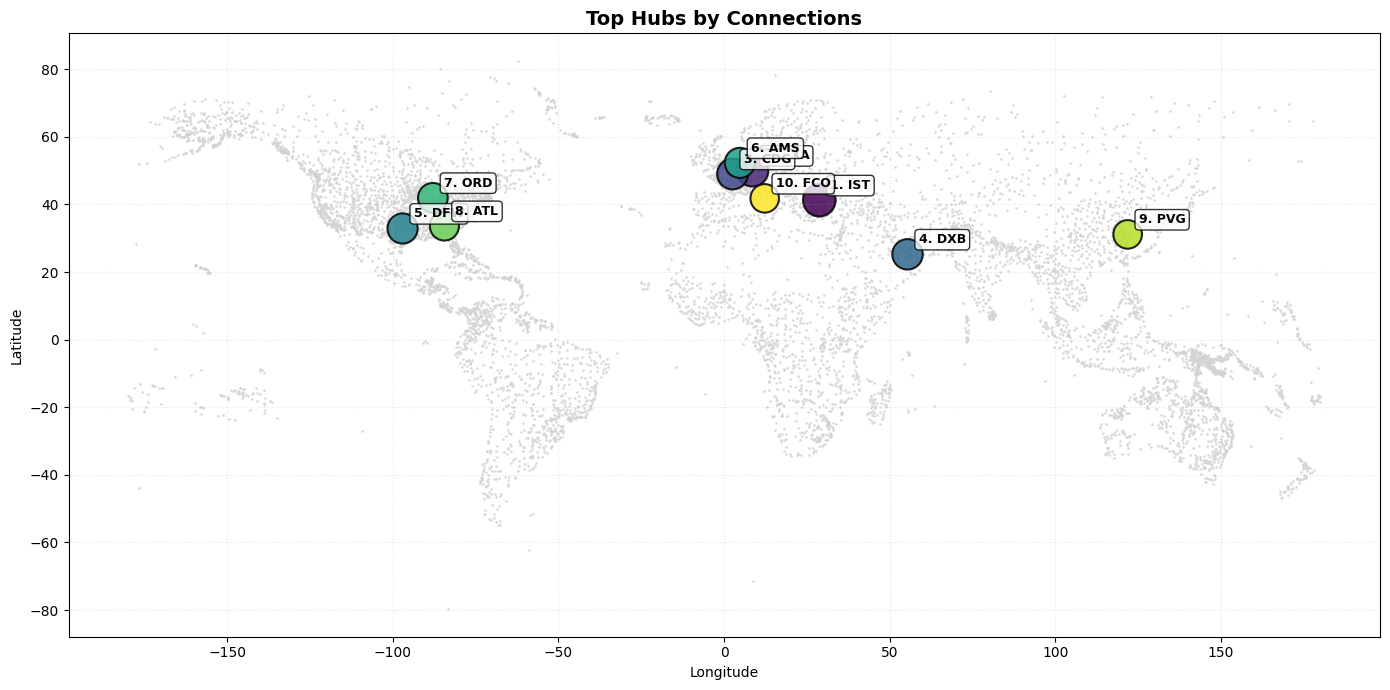

                                                  name  Connections  \
IST                                   İstanbul Airport          613   
FRA                                  Frankfurt Airport          582   
CDG            Charles de Gaulle International Airport          543   
DXB                        Dubai International Airport          529   
DFW            Dallas Fort Worth International Airport          518   
AMS                         Amsterdam Airport Schiphol          516   
ORD               Chicago O'Hare International Airport          499   
ATL   Hartsfield Jackson Atlanta International Airport          478   
PVG              Shanghai Pudong International Airport          459   
FCO  Rome–Fiumicino Leonardo da Vinci International...          455   

    iso_country continent  
IST          TR        EU  
FRA          DE        EU  
CDG          FR        EU  
DXB          AE        AS  
DFW          US        NA  
AMS          NL        EU  
ORD          US       

In [3]:
def analyze_hubs_with_map(G, airports_df, continent_filter=None, top_n=10, show_map=True):
    """
    Finds hubs and optionally displays them on a map.
    If continent_filter is ('NA', 'EU'), finds hubs connecting those two continents.
    """
    if continent_filter:
        cont_a, cont_b = continent_filter
        traffic = {}
        for u, v in G.edges():
            try:
                c_u = airports_df.loc[u, 'continent']
                c_v = airports_df.loc[v, 'continent']
                if {c_u, c_v} == {cont_a, cont_b}:
                    traffic[u] = traffic.get(u, 0) + 1
                    traffic[v] = traffic.get(v, 0) + 1
            except KeyError: 
                continue
        scores = traffic
    else:
        scores = dict(G.degree())

    df = pd.DataFrame.from_dict(scores, orient='index', columns=['Connections'])
    df = df.join(airports_df[['name', 'iso_country', 'continent', 'latitude_deg', 'longitude_deg']], how='left')
    df = df.sort_values('Connections', ascending=False)
    
    top_hubs = df.head(top_n)
    
    if show_map and len(top_hubs) > 0:
        plt.figure(figsize=(14, 7))
        
        # Background: all airports in light gray
        plt.scatter(airports_df['longitude_deg'], airports_df['latitude_deg'], 
                    c='lightgray', s=1, alpha=0.7, label='All Airports')
        
        # Hub markers sized by connection count
        sizes = (top_hubs['Connections'] / top_hubs['Connections'].max()) * 500 + 50
        scatter = plt.scatter(top_hubs['longitude_deg'], top_hubs['latitude_deg'],
                              c=range(len(top_hubs)), cmap='viridis', s=sizes, 
                              edgecolors='black', linewidths=1.5, alpha=0.85)
        
        # Add labels for each hub
        for idx, (code, row) in enumerate(top_hubs.iterrows()):
            plt.annotate(f"{idx+1}. {code}", 
                         xy=(row['longitude_deg'], row['latitude_deg']),
                         xytext=(8, 8), textcoords='offset points',
                         fontsize=9, fontweight='bold',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        title = "Top Hubs by Connections" if not continent_filter else f"Top {cont_a}-{cont_b} Gateway Hubs"
        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True, alpha=0.3, linestyle=':')
        plt.tight_layout()
        plt.show()
    
    return df

# --- Usage ---
print("=" * 60)
print("TOP 10 GLOBAL HUBS (with Map)")
print("=" * 60)
global_hubs = analyze_hubs_with_map(G, airports, top_n=10, show_map=True)
print(global_hubs[['name', 'Connections', 'iso_country', 'continent']].head(10))


TOP 10 EUROPE-AMERICA INTERNAL HUBS (Filtered Airport Data)


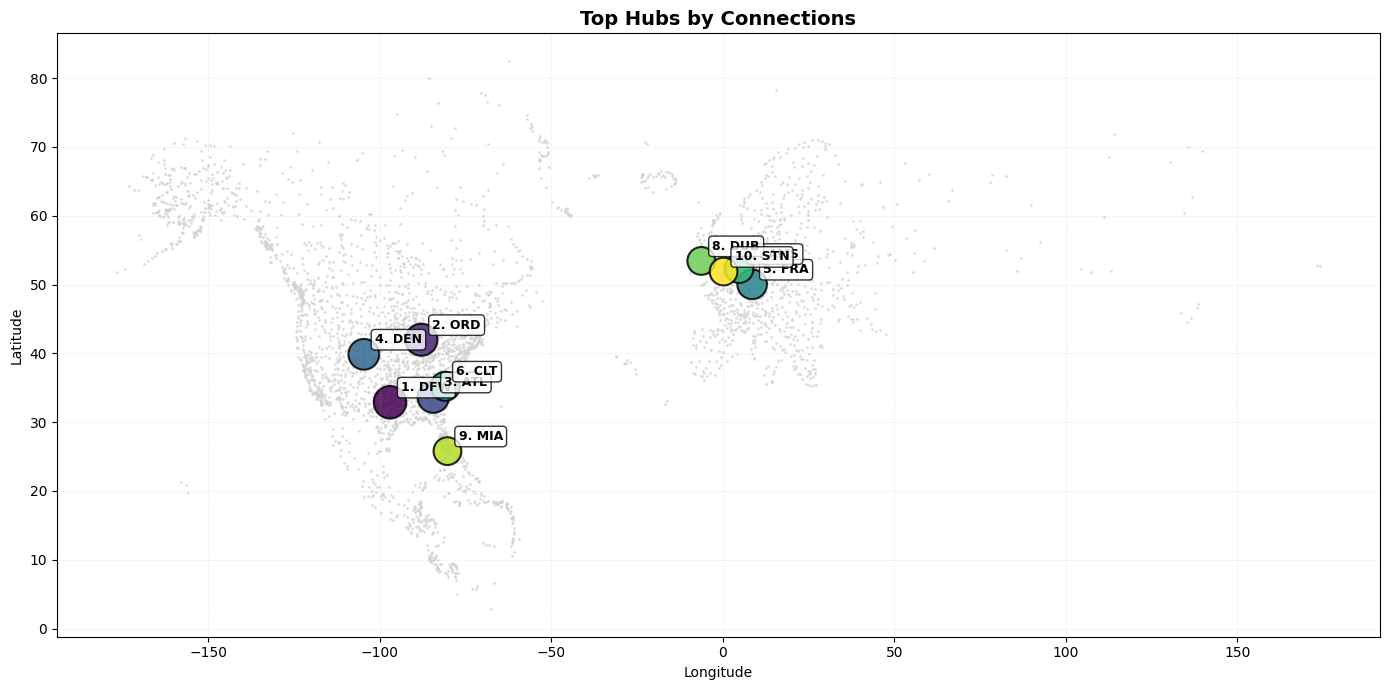

                                                 name  Connections  \
DFW           Dallas Fort Worth International Airport          486   
ORD              Chicago O'Hare International Airport          470   
ATL  Hartsfield Jackson Atlanta International Airport          449   
DEN                      Denver International Airport          428   
FRA                                 Frankfurt Airport          394   
CLT           Charlotte Douglas International Airport          379   
AMS                        Amsterdam Airport Schiphol          365   
DUB                                    Dublin Airport          341   
MIA                       Miami International Airport          340   
STN                           London Stansted Airport          339   

    iso_country continent  
DFW          US        NA  
ORD          US        NA  
ATL          US        NA  
DEN          US        NA  
FRA          DE        EU  
CLT          US        NA  
AMS          NL        EU  
DUB  

In [4]:
#Hubs in between EU and NA

airports_na_eu = airports[airports['continent'].isin(['EU', 'NA'])].copy()

G_na_eu = G.subgraph(airports_na_eu.index).copy()

print("\n" + "=" * 60)
print("TOP 10 EUROPE-AMERICA INTERNAL HUBS (Filtered Airport Data)")
print("=" * 60)
internal_hubs = analyze_hubs_with_map(
    G_na_eu,              # Use the filtered graph
    airports_na_eu,       # Use the filtered airports (provides correct continent data)
    continent_filter=None, # Calculate degree (internal connections)
    top_n=10, 
    show_map=True
)
print(internal_hubs[['name', 'Connections', 'iso_country', 'continent']].head(10))

**3. International Connectivity**

This analysis measures which countries are most integrated into the global aviation network by calculating the percentage of routes that cross borders. 
We distinguish between international routes (crossing countries) and intercontinental routes (crossing continents) to understand different levels of global connection. 
Small nations and strategic hub countries (like Netherlands, UAE) typically show higher international rates, while large countries (USA, China) have more domestic routes.

In [5]:
import pandas as pd
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple, Union

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_data():
    # Load Airports
    airports = pd.read_csv('airports_new.csv', keep_default_na=False, na_values=[''])
    airports = airports.dropna(subset=['iata_code']).drop_duplicates(subset=['iata_code'])
    airports.set_index('iata_code', inplace=True)

    # Load Routes (DAT) for country/continent analysis
    route_cols = ['Airline', 'AirlineID', 'Source', 'SourceID', 'Dest', 'DestID', 'Codeshare', 'Stops', 'Equipment']
    routes_dat = pd.read_csv('routes_new.dat', header=None, names=route_cols)
    routes_dat['Source'] = routes_dat['Source'].astype(str)
    routes_dat['Dest'] = routes_dat['Dest'].astype(str)
    
    # Pre-merge Route Data with Geo Info
    routes_merged = routes_dat.merge(airports[['iso_country', 'continent']], 
                                     left_on='Source', right_index=True)
    routes_merged = routes_merged.rename(columns={'iso_country': 'src_country', 'continent': 'src_continent'})
    
    routes_merged = routes_merged.merge(airports[['iso_country', 'continent']], 
                                     left_on='Dest', right_index=True)
    routes_merged = routes_merged.rename(columns={'iso_country': 'dst_country', 'continent': 'dst_continent'})
    
    # Load Countries and prepare for merge
    countries_df = pd.read_csv('countries_20190227.csv', usecols=['code', 'name'])
    countries_df.set_index('code', inplace=True)
    countries_df.index.name = 'iso_country' # Align index name for join
    
    return airports, routes_merged, countries_df # Return countries_df

# --- 2. Country Rate Analysis with Map Visualization (Improved) ---

def analyze_country_rates_with_maps(routes_merged_df, airports_df, countries_df, top_n=10):
    """
    Calculates domestic, international, and intercontinental metrics per country.
    Visualizes countries on the map using their geographical centroids.
    """
    # 1. Calculate flight flags
    df = routes_merged_df.copy()
    df['is_domestic'] = df['src_country'] == df['dst_country']
    df['is_intercontinental'] = df['src_continent'] != df['dst_continent']
    df['is_intl'] = ~df['is_domestic']
    
    # 2. Group by source country for statistics
    country_stats = df.groupby('src_country').agg(
        Total_Flights=('Source', 'count'),
        Domestic_Flights=('is_domestic', 'sum'),
        International_Flights=('is_intl', 'sum'),
        Intercontinental_Flights=('is_intercontinental', 'sum')
    )
    
    # 3. Calculate Rates
    country_stats['Domestic_Rate'] = country_stats['Domestic_Flights'] / country_stats['Total_Flights']
    country_stats['Intl_Rate'] = country_stats['International_Flights'] / country_stats['Total_Flights']
    country_stats['Intercontinental_Rate'] = country_stats['Intercontinental_Flights'] / country_stats['Total_Flights']
    
    # 4. Calculate Country Centroids (Average of airport coordinates)
    country_centroids = airports_df.groupby('iso_country').agg(
        lat=('latitude_deg', 'mean'),
        lon=('longitude_deg', 'mean')
    )
    country_stats = country_stats.join(country_centroids)

    country_stats = country_stats.join(countries_df, how='left')
    country_stats = country_stats.rename(columns={'name': 'Country_Name'})
    
    # Filter for countries with significant traffic (at least 50 flights)
    significant = country_stats[country_stats['Total_Flights'] >= 50].copy()
    
    # Define metrics to display/plot
    metrics = [
        ('Total_Flights', 'Total Flight Volume'),
        ('Domestic_Flights', 'Domestic Flight Volume'),
        ('International_Flights', 'International Flight Volume'),
        ('Intercontinental_Flights', 'Intercontinental Flight Volume'),
        ('Domestic_Rate', 'Domestic Rate'),
        ('Intl_Rate', 'International Rate'),
        ('Intercontinental_Rate', 'Intercontinental Rate')
    ]

    
    for score_col, label in metrics:
        top_countries = significant.sort_values(score_col, ascending=False).head(top_n)
        
        print("\n" + "=" * 70)
        print(f"TOP {top_n} COUNTRIES BY {label.upper()}")
        print("=" * 70)
        cols_to_show = ['Country_Name', 'Total_Flights', 'Domestic_Flights', 'International_Flights', 'Intercontinental_Flights', score_col]
        print(top_countries[cols_to_show].to_string())
    
    return country_stats

# --- Execute ---
try:
    airports, routes_merged, countries_df = load_and_preprocess_data()
    country_rates = analyze_country_rates_with_maps(routes_merged, airports, countries_df, top_n=10)
except FileNotFoundError as e:
    print(f"\nERROR: Could not run the analysis because a required file is missing: {e.filename}")
    print("Please ensure 'airports_new.csv' and 'routes_new.dat' are available along with 'countries_20190227.csv'.")


TOP 10 COUNTRIES BY TOTAL FLIGHT VOLUME
               Country_Name  Total_Flights  Domestic_Flights  International_Flights  Intercontinental_Flights  Total_Flights
src_country                                                                                                                 
US            United States          13198             10702                   2496                      1304          13198
CN                    China           8222              7040                   1182                       229           8222
GB           United Kingdom           2615               309                   2306                       882           2615
ES                    Spain           2466               577                   1889                       796           2466
DE                  Germany           2024               152                   1872                       652           2024
FR                   France           1901               483                   1418 

**4. Flight Clusters and Communities**

We use clustering algorithms to discover natural groupings in the aviation network - regions where airports are densely interconnected. 
The code implements both Louvain (graph-based connectivity) and K-Means (geographic proximity) to compare network structure versus geographic patterns. 
Results reveal regional aviation markets and show how airlines organize operations into geographic zones.

WORLD FLIGHT COMMUNITIES ANALYSIS
Which parts of the world are most interconnected by flights?

Analyzing 3702 airports with 28243 flight connections...
Found 17 major flight communities



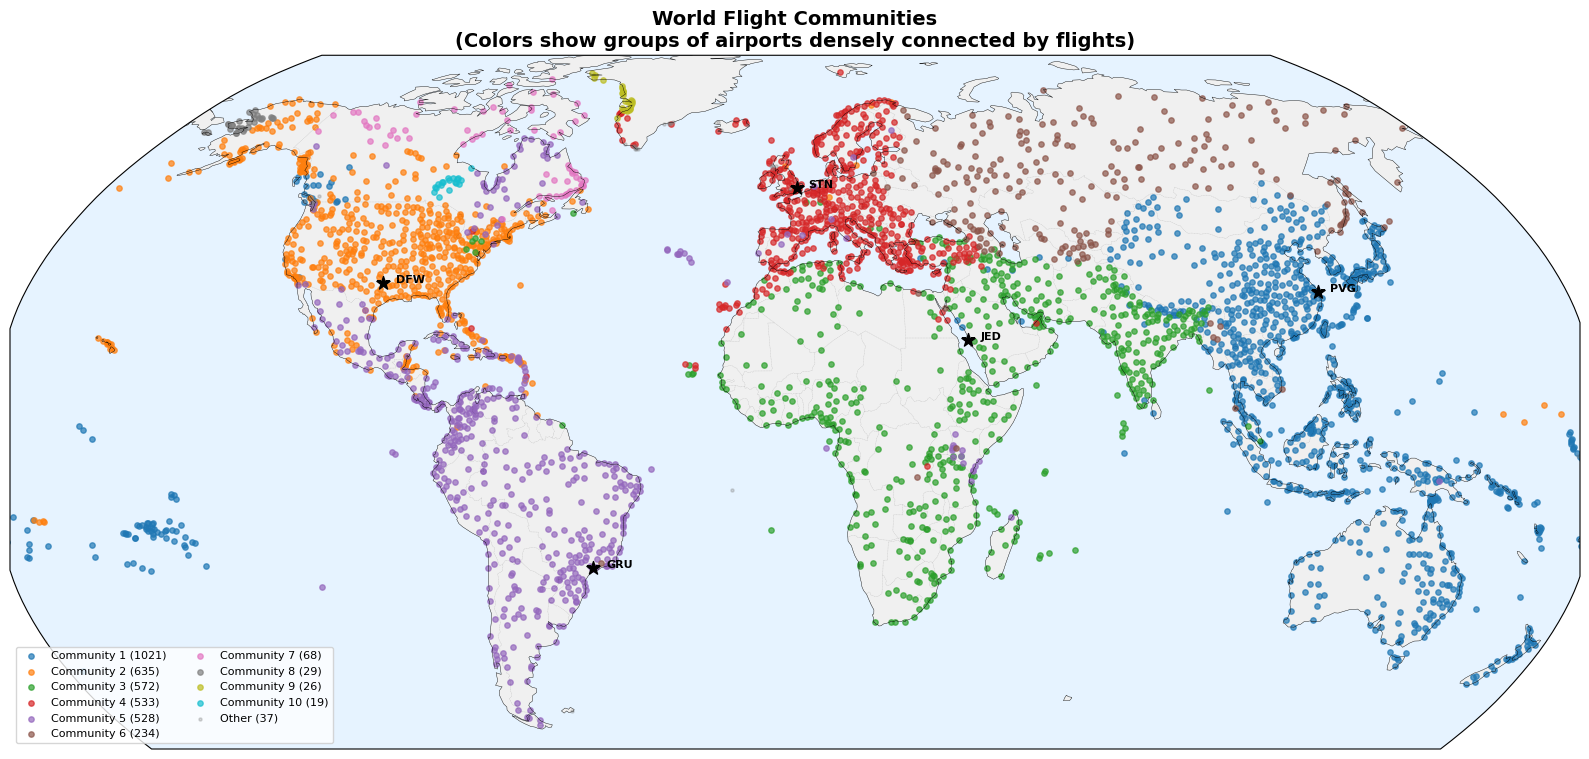

In [6]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import matplotlib.pyplot as plt

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAS_CARTOPY = True
except ImportError:
    HAS_CARTOPY = False
    print("ERROR: Requires cartopy. Install with: pip install cartopy")


def analyze_world_flight_communities(G, airports_df, routes_json):
    """
    Identifies which parts of the world form flight communities.
    Uses Louvain community detection on the flight network.

    Returns communities with their geographic and country composition.
    """

    print("=" * 80)
    print("WORLD FLIGHT COMMUNITIES ANALYSIS")
    print("Which parts of the world are most interconnected by flights?")
    print("=" * 80)

    # Convert to undirected for community detection
    G_undirected = G.to_undirected()

    # Get largest connected component
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G_cc = G_undirected.subgraph(largest_cc).copy()

    print(f"\nAnalyzing {G_cc.number_of_nodes()} airports with {G_cc.number_of_edges()} flight connections...")

    # Detect communities using Louvain algorithm
    communities = nx_comm.louvain_communities(G_cc, seed=42, resolution=1.0)

    print(f"Found {len(communities)} major flight communities\n")

    community_data = []

    for idx, comm in enumerate(sorted(communities, key=len, reverse=True)):
        comm_airports = airports_df[airports_df.index.isin(comm)].copy()

        if len(comm_airports) == 0:
            continue

        country_counts = comm_airports['iso_country'].value_counts()
        continent_counts = comm_airports['continent'].value_counts()

        subgraph = G_cc.subgraph(comm)
        degrees = dict(subgraph.degree())

        if degrees:
            hub = max(degrees, key=degrees.get)
            hub_name = airports_df.loc[hub, 'name'] if hub in airports_df.index else hub
        else:
            hub = list(comm)[0]
            hub_name = hub

        community_data.append({
            'id': idx,
            'size': len(comm),
            'airports': comm,
            'top_countries': country_counts.head(5).to_dict(),
            'continents': continent_counts.to_dict(),
            'hub': hub,
            'hub_name': hub_name,
            'avg_lat': comm_airports['latitude_deg'].mean(),
            'avg_lon': comm_airports['longitude_deg'].mean()
        })

    # ===========================
    # VISUALIZATION
    # ===========================

    airport_communities = {}
    for comm in community_data:
        for airport in comm['airports']:
            airport_communities[airport] = comm['id']

    plot_df = airports_df[airports_df.index.isin(airport_communities.keys())].copy()
    plot_df['community'] = plot_df.index.map(airport_communities)

    n_colors = 10
    plot_df['color_group'] = plot_df['community'].apply(lambda x: x if x < n_colors else n_colors)

    # === NEW: compute map bounds from airports ===
    min_lon = plot_df['longitude_deg'].min()
    max_lon = plot_df['longitude_deg'].max()
    min_lat = plot_df['latitude_deg'].min()
    max_lat = plot_df['latitude_deg'].max()

    pad_lon = 5
    pad_lat = 5

    if HAS_CARTOPY:
        fig = plt.figure(figsize=(16, 10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

        # === CHANGED: zoom map to airport extent ===
        ax.set_extent(
            [min_lon - pad_lon, max_lon + pad_lon,
             min_lat - pad_lat, max_lat + pad_lat],
            crs=ccrs.PlateCarree()
        )

        ax.add_feature(cfeature.LAND, facecolor='#f0f0f0')
        ax.add_feature(cfeature.OCEAN, facecolor='#e6f3ff')
        ax.add_feature(cfeature.COASTLINE, linewidth=0.3)
        ax.add_feature(cfeature.BORDERS, linewidth=0.2, linestyle=':', alpha=0.5)

        colors = plt.cm.tab10(np.linspace(0, 1, n_colors + 1))

        for comm_id in range(n_colors):
            comm_df = plot_df[plot_df['community'] == comm_id]
            if len(comm_df) > 0:
                ax.scatter(
                    comm_df['longitude_deg'],
                    comm_df['latitude_deg'],
                    c=[colors[comm_id]],
                    s=15,
                    alpha=0.7,
                    transform=ccrs.PlateCarree(),
                    label=f"Community {comm_id + 1} ({len(comm_df)})"
                )

        other_df = plot_df[plot_df['community'] >= n_colors]
        if len(other_df) > 0:
            ax.scatter(
                other_df['longitude_deg'],
                other_df['latitude_deg'],
                c='gray',
                s=5,
                alpha=0.3,
                transform=ccrs.PlateCarree(),
                label=f"Other ({len(other_df)})"
            )

        for comm in community_data[:5]:
            if comm['hub'] in airports_df.index:
                hub_data = airports_df.loc[comm['hub']]
                ax.scatter(
                    hub_data['longitude_deg'],
                    hub_data['latitude_deg'],
                    c='black',
                    s=100,
                    marker='*',
                    transform=ccrs.PlateCarree(),
                    zorder=10
                )
                ax.text(
                    hub_data['longitude_deg'] + 3,
                    hub_data['latitude_deg'],
                    comm['hub'],
                    fontsize=8,
                    fontweight='bold',
                    transform=ccrs.PlateCarree()
                )

        ax.legend(loc='lower left', fontsize=8, ncol=2)

    else:
        fig, ax = plt.subplots(figsize=(16, 10))

        colors = plt.cm.tab10(np.linspace(0, 1, n_colors))

        for comm_id in range(n_colors):
            comm_df = plot_df[plot_df['community'] == comm_id]
            if len(comm_df) > 0:
                ax.scatter(
                    comm_df['longitude_deg'],
                    comm_df['latitude_deg'],
                    c=[colors[comm_id]],
                    s=15,
                    alpha=0.7,
                    label=f"Community {comm_id + 1} ({len(comm_df)})"
                )

        other_df = plot_df[plot_df['community'] >= n_colors]
        if len(other_df) > 0:
            ax.scatter(
                other_df['longitude_deg'],
                other_df['latitude_deg'],
                c='gray',
                s=5,
                alpha=0.3,
                label=f"Other ({len(other_df)})"
            )

        for comm in community_data[:5]:
            if comm['hub'] in airports_df.index:
                hub_data = airports_df.loc[comm['hub']]
                ax.scatter(
                    hub_data['longitude_deg'],
                    hub_data['latitude_deg'],
                    c='black',
                    s=150,
                    marker='*',
                    zorder=10
                )
                ax.annotate(
                    comm['hub'],
                    xy=(hub_data['longitude_deg'], hub_data['latitude_deg']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8,
                    fontweight='bold'
                )

        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend(loc='lower left', fontsize=8, ncol=2)

    plt.title(
        "World Flight Communities\n(Colors show groups of airports densely connected by flights)",
        fontsize=14,
        fontweight='bold'
    )

    plt.tight_layout()
    plt.show()

    return community_data, plot_df


def show_community_connections(community_data, G, airports_df, comm_id=0):
    """
    Shows how one community connects to other communities.
    """

    if comm_id >= len(community_data):
        print(f"Community {comm_id} not found")
        return

    comm = community_data[comm_id]

    external_connections = {}

    for airport in comm['airports']:
        if airport in G:
            for neighbor in G.neighbors(airport):
                if neighbor not in comm['airports']:
                    for other_comm in community_data:
                        if neighbor in other_comm['airports']:
                            other_id = other_comm['id']
                            if other_id not in external_connections:
                                external_connections[other_id] = {'count': 0, 'routes': []}
                            external_connections[other_id]['count'] += 1
                            external_connections[other_id]['routes'].append((airport, neighbor))
                            break


# =============================================================================
# USAGE
# =============================================================================
community_data, community_df = analyze_world_flight_communities(
    G_global, airports, routes_json
)

show_community_connections(community_data, G_global, airports, comm_id=0)
show_community_connections(community_data, G_global, airports, comm_id=1)


--- Data Loading and Filtering Complete ---
European Network Nodes: 531, Edges: 9254
WORLD FLIGHT COMMUNITIES ANALYSIS
Which parts of the world are most interconnected by flights?

Analyzing 527 airports with 4672 flight connections...
Found 7 major flight communities



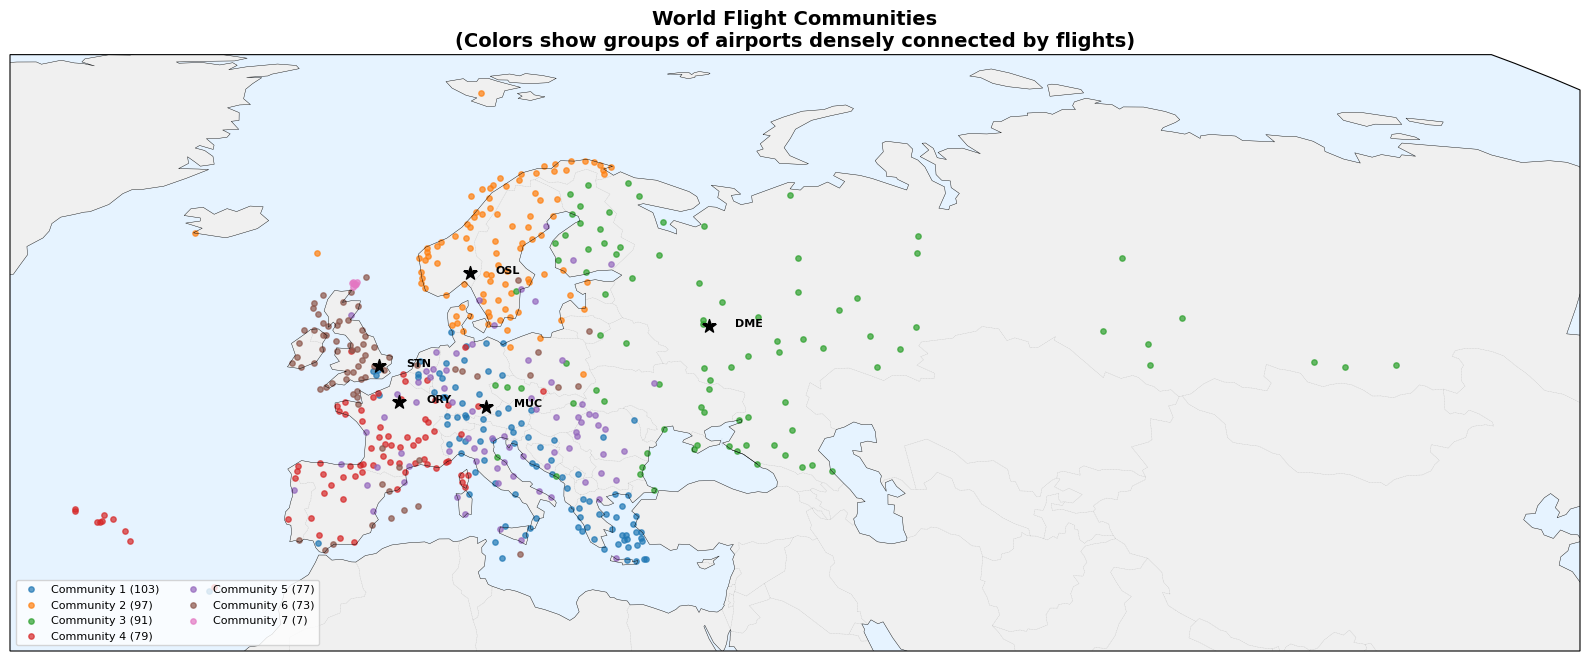

In [7]:
#Europe only now

import pandas as pd
import networkx as nx
import numpy as np
import networkx.algorithms.community as nx_comm

def load_data_and_filter_europe():
    """
    Loads data and filters it to include only flights with both source and 
    destination in Europe ('EU'), and returns the graph and filtered dataframes.
    
    Variables are named G_global, airports, routes_json to match the user's 
    requested execution block.
    """
    
    # Load Airports
    airports_df = pd.read_csv('airports_new.csv', keep_default_na=False, na_values=[''])
    airports_df = airports_df.dropna(subset=['iata_code']).drop_duplicates(subset=['iata_code'])
    airports_df.set_index('iata_code', inplace=True)
    
    # Load Routes (DAT)
    route_cols = ['Airline', 'AirlineID', 'Source', 'SourceID', 'Dest', 'DestID', 'Codeshare', 'Stops', 'Equipment']
    routes_dat = pd.read_csv('routes_new.dat', header=None, names=route_cols)
    routes_dat['Source'] = routes_dat['Source'].astype(str)
    routes_dat['Dest'] = routes_dat['Dest'].astype(str)
    # routes_json is required by function signature, but not used in the core logic below.
    routes_json = routes_dat.to_dict('records') 
    
    # 1. Filter airports to Europe only
    airports_europe = airports_df[airports_df['continent'] == 'EU'].copy()
    europe_airport_codes = set(airports_europe.index)
    
    # Merge routes to get continent/country info for filtering
    routes_merged = routes_dat.merge(airports_df[['iso_country', 'continent']],
                                     left_on='Source', right_index=True, how='inner')
    routes_merged = routes_merged.merge(airports_df[['iso_country', 'continent']],
                                     left_on='Dest', right_index=True, how='inner', suffixes=('_src', '_dst'))
    
    # 2. Filter routes: both source AND destination must be in Europe
    routes_europe = routes_merged[
        (routes_merged['continent_src'] == 'EU') &
        (routes_merged['continent_dst'] == 'EU')
    ].copy()

    # 3. Create NetworkX graph for Europe
    G_europe = nx.DiGraph()
    G_europe.add_edges_from(routes_europe[['Source', 'Dest']].to_numpy())
    
    print("--- Data Loading and Filtering Complete ---")
    print(f"European Network Nodes: {G_europe.number_of_nodes()}, Edges: {G_europe.number_of_edges()}")
    
    return G_europe, airports_europe, routes_json


if __name__ == '__main__':
    try:
        G_global_eu, airports_eu, routes_json_eu = load_data_and_filter_europe()
        
        community_data, community_df = analyze_world_flight_communities(G_global_eu, airports_eu, routes_json_eu)

        show_community_connections(community_data, G_global, airports, comm_id=0)  # Largest community
        show_community_connections(community_data, G_global, airports, comm_id=1)  # Second largest

    except FileNotFoundError as e:
        print(f"\n[ERROR] Required file not found. Ensure 'airports_new.csv' and 'routes_new.dat' are available.")
    except Exception as e:
        print(f"\n[ERROR] An unexpected error occurred: {e}")

        

**5. Geographic Outliers**

This section identifies airports at geographic extremes - northernmost, southernmost, westernmost, easternmost and highest altitude. 
We can narrow down the search to a continent or a country.



EUROPE GEOGRAPHIC OUTLIERS
North   : [LYR] Svalbard Airport, Longyear
          Lat: 78.25°, Lon: 15.47°
South   : [FNC] Madeira International Airport Cristiano 
          Lat: 32.70°, Lon: -16.77°
East    : [DPT] Deputatskiy Airport
          Lat: 69.39°, Lon: 139.89°
West    : [PVS] Provideniya Bay Airport
          Lat: 64.38°, Lon: -173.24°
Highest : [CVF] Courchevel Altiport
          Lat: 45.40°, Lon: 6.63°, Elev: 6583 ft


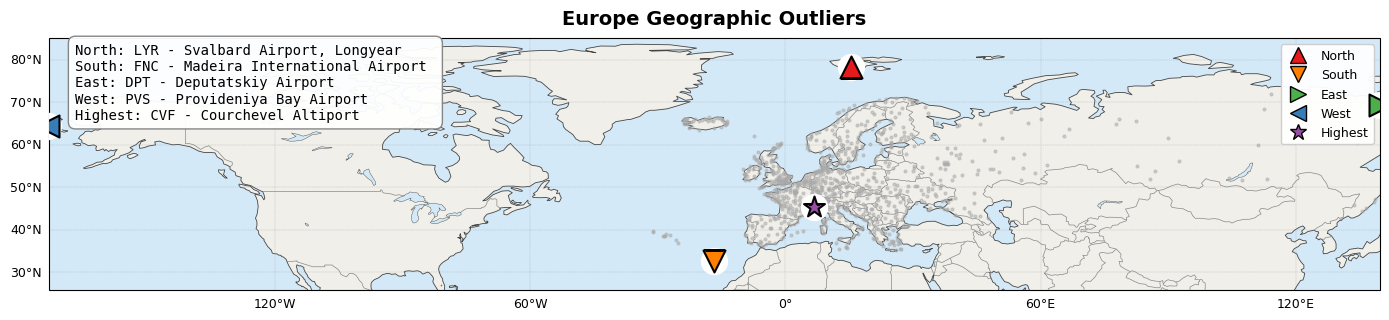



GERMANY GEOGRAPHIC OUTLIERS
North   : [GWT] Westerland Sylt Airport
          Lat: 54.91°, Lon: 8.34°
South   : [FDH] Friedrichshafen Airport
          Lat: 47.67°, Lon: 9.51°
East    : [HDF] Heringsdorf Airport
          Lat: 53.88°, Lon: 14.15°
West    : [GKE] Geilenkirchen Air Base
          Lat: 50.96°, Lon: 6.04°
Highest : [FMM] Memmingen Allgau Airport
          Lat: 47.99°, Lon: 10.24°, Elev: 2077 ft


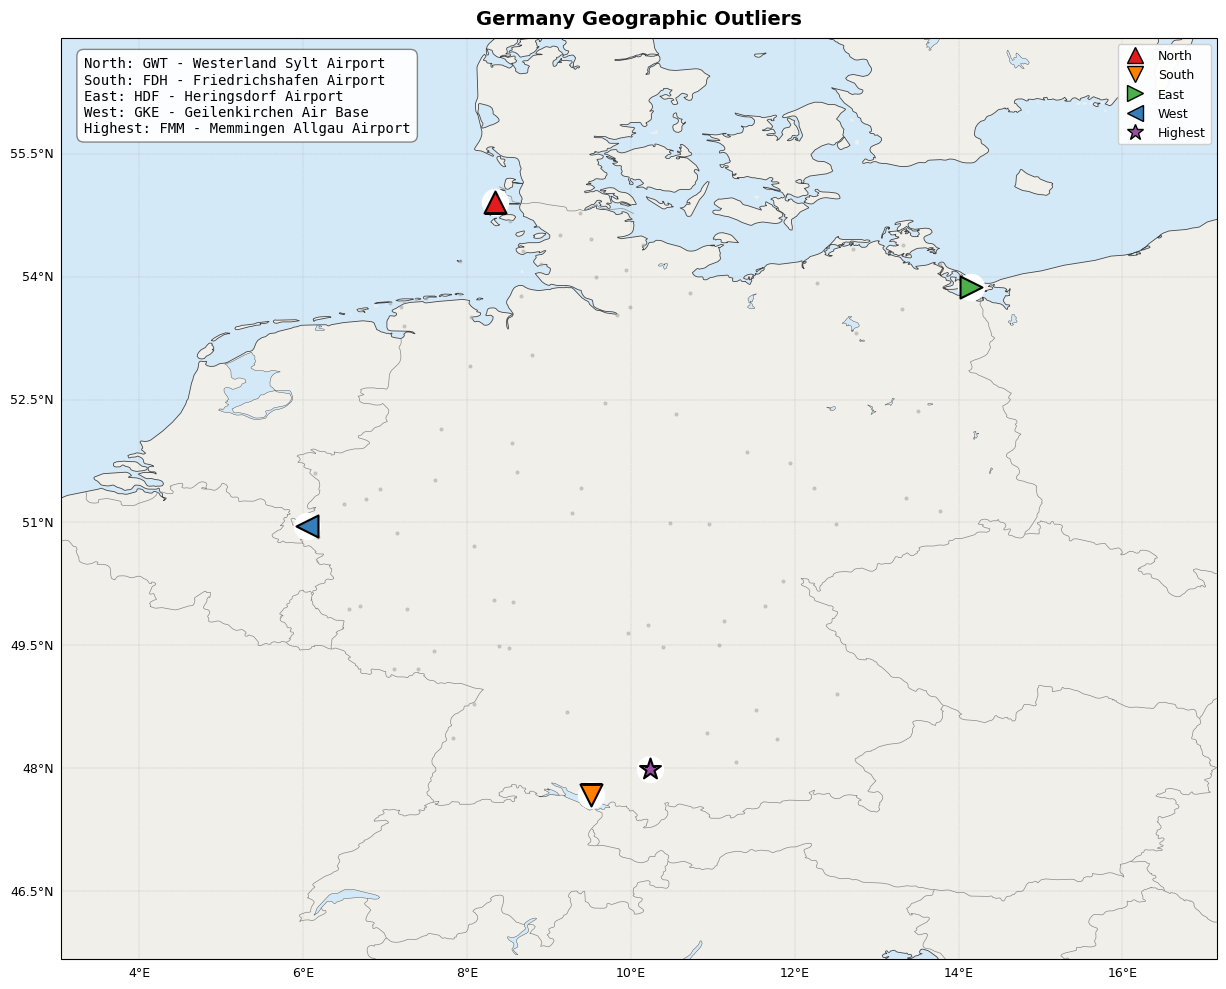

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def show_outliers(airports_df, region_filter, region_name, filter_type='continent'):
    """
    Shows geographic outliers for any region.
    
    Parameters:
    -----------
    airports_df : DataFrame
    region_filter : str - e.g., 'EU' for continent or 'DE' for country
    region_name : str - e.g., 'Europe' or 'Germany'
    filter_type : str - 'continent' or 'country'
    """
    
    if not HAS_CARTOPY:
        print("Please install cartopy: pip install cartopy")
        return None
    
    # Filter airports
    if filter_type == 'continent':
        region_airports = airports_df[airports_df['continent'] == region_filter].copy()
    else:
        region_airports = airports_df[airports_df['iso_country'] == region_filter].copy()
    
    if len(region_airports) == 0:
        print(f"No airports found for {region_name}")
        return None
    
    # Find outliers
    outliers = {
        'North': {'idx': region_airports['latitude_deg'].idxmax(), 'color': '#e41a1c', 'marker': '^'},
        'South': {'idx': region_airports['latitude_deg'].idxmin(), 'color': '#ff7f00', 'marker': 'v'},
        'East': {'idx': region_airports['longitude_deg'].idxmax(), 'color': '#4daf4a', 'marker': '>'},
        'West': {'idx': region_airports['longitude_deg'].idxmin(), 'color': '#377eb8', 'marker': '<'},
        'Highest': {'idx': region_airports['elevation_ft'].idxmax(), 'color': '#984ea3', 'marker': '*'}
    }
    
    # Get data for each outlier
    for key in outliers:
        outliers[key]['data'] = region_airports.loc[outliers[key]['idx']]
    
    # Print info
    print("=" * 70)
    print(f"{region_name.upper()} GEOGRAPHIC OUTLIERS")
    print("=" * 70)
    
    for label, info in outliers.items():
        row = info['data']
        code = row.name
        print(f"{label:8}: [{code}] {row['name'][:40]}")
        print(f"          Lat: {row['latitude_deg']:.2f}°, Lon: {row['longitude_deg']:.2f}°", end="")
        if label == 'Highest':
            print(f", Elev: {row['elevation_ft']:.0f} ft")
        else:
            print()
    
    # Calculate bounds
    outlier_lats = [info['data']['latitude_deg'] for info in outliers.values()]
    outlier_lons = [info['data']['longitude_deg'] for info in outliers.values()]
    
    lat_range = max(outlier_lats) - min(outlier_lats)
    lon_range = max(outlier_lons) - min(outlier_lons)
    
    # Padding proportional to range (minimum 2 degrees)
    lat_pad = max(lat_range * 0.15, 2)
    lon_pad = max(lon_range * 0.15, 3)
    
    lat_min = min(outlier_lats) - lat_pad
    lat_max = max(outlier_lats) + lat_pad
    lon_min = min(outlier_lons) - lon_pad
    lon_max = max(outlier_lons) + lon_pad
    
    # Create figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    
    # Map features
    ax.add_feature(cfeature.LAND, facecolor='#f0efe9')
    ax.add_feature(cfeature.OCEAN, facecolor='#d4e9f7')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='#444444')
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor='#888888')
    ax.add_feature(cfeature.LAKES, facecolor='#d4e9f7', edgecolor='#444444', linewidth=0.3)
    
    # Background airports (small, subtle)
    in_view = region_airports[
        (region_airports['latitude_deg'] >= lat_min) &
        (region_airports['latitude_deg'] <= lat_max) &
        (region_airports['longitude_deg'] >= lon_min) &
        (region_airports['longitude_deg'] <= lon_max)
    ]
    ax.scatter(in_view['longitude_deg'], in_view['latitude_deg'],
              c='#aaaaaa', s=4, alpha=0.5, transform=ccrs.PlateCarree(), zorder=2)
    
    # Plot outliers - just markers, no clutter
    for label, info in outliers.items():
        row = info['data']
        code = row.name
        
        # White halo for visibility
        ax.scatter(row['longitude_deg'], row['latitude_deg'],
                  c='white', s=350, marker='o',
                  transform=ccrs.PlateCarree(), zorder=8)
        
        # Colored marker
        ax.scatter(row['longitude_deg'], row['latitude_deg'],
                  c=info['color'], s=250, marker=info['marker'],
                  edgecolors='black', linewidths=1.5,
                  transform=ccrs.PlateCarree(), zorder=10)
    
    # Simple legend outside plot - no annotations on map
    legend_text = []
    for label, info in outliers.items():
        row = info['data']
        code = row.name
        legend_text.append(f"{label}: {code} - {row['name'][:30]}")
    
    # Add legend as text box
    textstr = '\n'.join(legend_text)
    props = dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray', alpha=0.95)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace', bbox=props, zorder=20)
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 9}
    gl.ylabel_style = {'size': 9}
    
    # Color legend for markers
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker=info['marker'], color='w', markerfacecolor=info['color'],
               markeredgecolor='black', markersize=12, label=label)
        for label, info in outliers.items()
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.95)
    
    plt.title(f"{region_name} Geographic Outliers", fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    plt.show()
    
    return outliers


# =============================================================================
# USAGE
# =============================================================================

# European outliers
print("\n")
eu_outliers = show_outliers(airports, 'EU', 'Europe', filter_type='continent')

# German outliers
print("\n")
de_outliers = show_outliers(airports, 'DE', 'Germany', filter_type='country')

**6. Nearest Neighbors and Navaids**

Using BallTree spatial indexing with the haversine metric, we can instantly find the closest airports or navigation aids to any location. 
This allows us to see and put on map what it next to any given airport.

Setup Complete. Loaded 9065 airports and built network with 55510 routes.
NEIGHBORHOOD OF LHR (London Heathrow Airport)

Nearest Airports:
  1. NHT - RAF Northolt: 9.65 km
  2. HYC - Wycombe Air Park: 28.64 km
  3. FAB - Farnborough Airport: 30.75 km
  4. BBS - Blackbushe Airport: 31.33 km
  5. LCY - London City Airport: 36.02 km

Nearest Navaids:
  1. LON - London: 1.87 km
  2. FOS - Fairoaks: 15.47 km
  3. FRK - Fairoaks: 15.47 km
  4. BUR - Burnham: 15.84 km
  5. CHT - Chiltern: 17.40 km


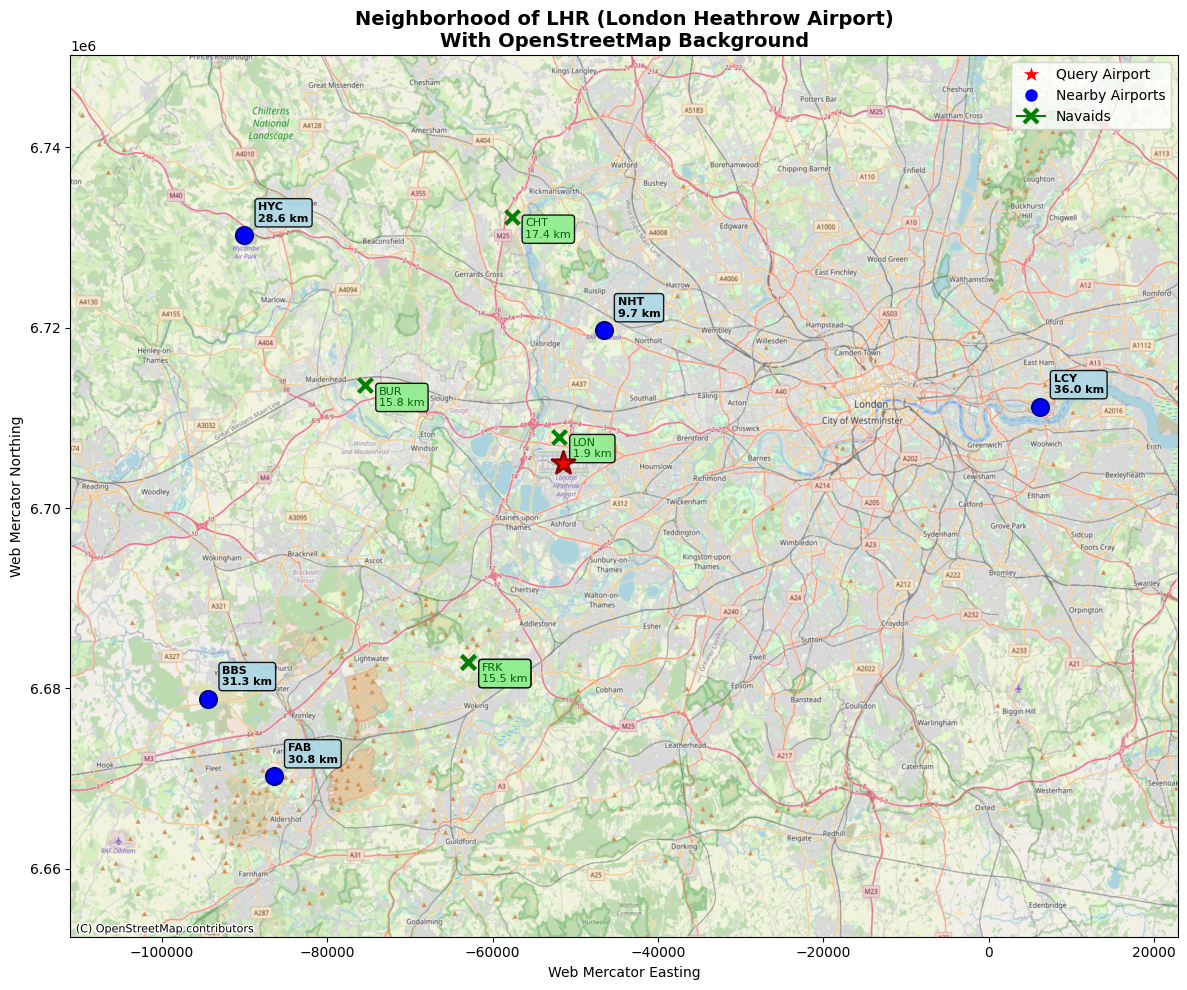

NEIGHBORHOOD OF LAX (Los Angeles International Airport)

Nearest Airports:
  1. HHR - Jack Northrop Field Hawthorne Municipal Airport: 7.08 km
  2. SMO - Santa Monica Municipal Airport: 9.06 km
  3. CCD - Century City Heliport: 13.19 km
  4. CPM - Compton Woodley Airport: 16.22 km
  5. TOA - Zamperini Field: 16.69 km

Nearest Navaids:
  1. LAX - Los Angeles: 2.45 km
  2. SMO - Santa Monica: 8.78 km
  3. OS - Romen: 12.23 km
  4. CPM - Compton: 16.01 km
  5. VNY - Van Nuys: 32.18 km


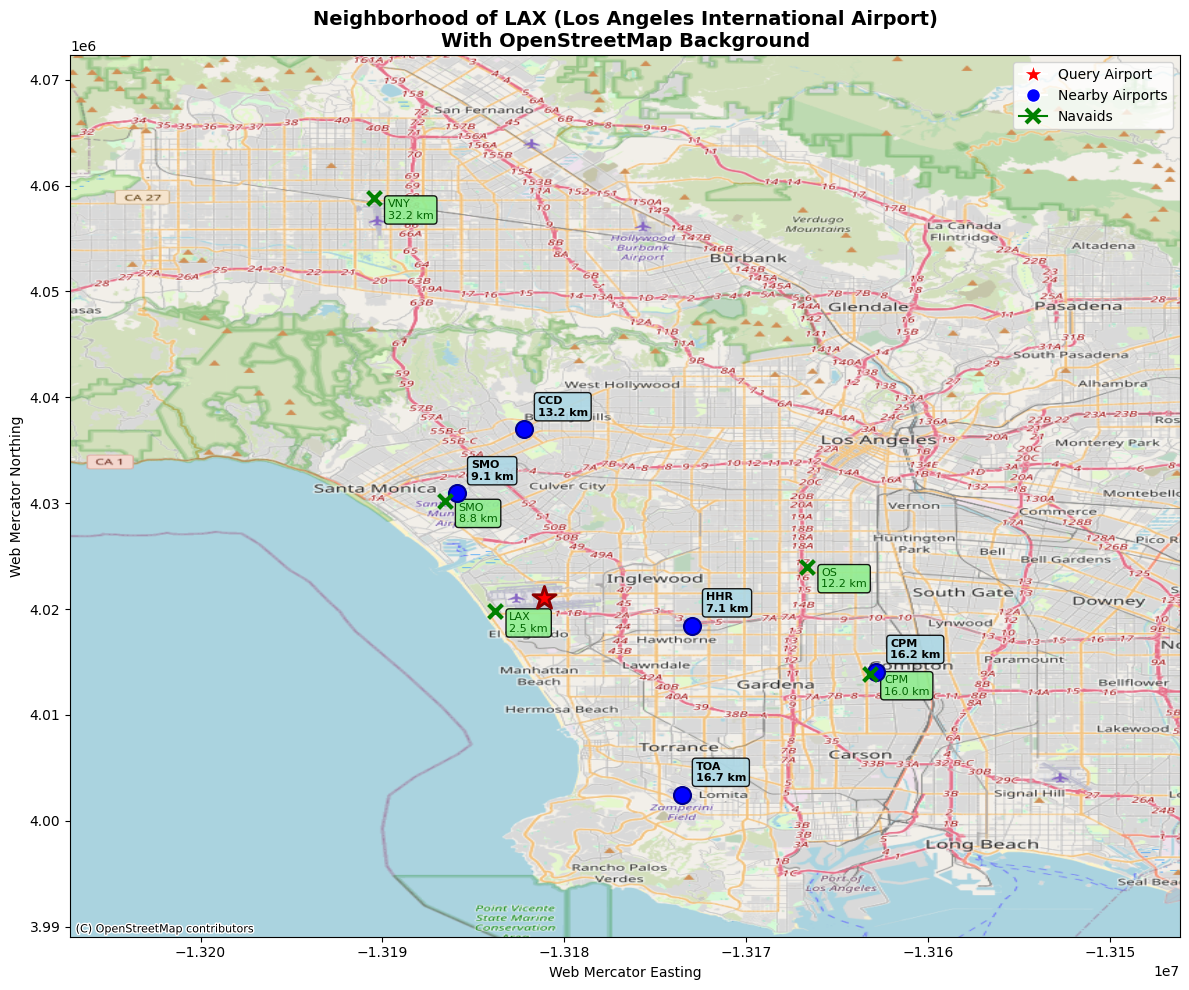

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def show_airport_neighborhood_with_background(
    airports_df,
    navaids_df,
    target,
    k=5,
    zoom=11
):
    """
    Shows neighborhood of ANY airport with OpenStreetMap background tiles.

    Parameters
    ----------
    airports_df : DataFrame
    navaids_df : DataFrame
    target : str
        Airport code (ICAO/IATA) present in airports_df.index
    k : int
        Number of nearest airports / navaids
    zoom : int
        OSM zoom level
    """
    import contextily as ctx
    from pyproj import Transformer

    if target not in airports_df.index:
        print(f"Airport '{target}' not found!")
        return

    airport = airports_df.loc[target]
    name = airport.get("name", target)

    lat = airport['latitude_deg']
    lon = airport['longitude_deg']

    nearby_data = get_nearest(target, airports_df, navaids_df, k=k)

    print("=" * 70)
    print(f"NEIGHBORHOOD OF {target} ({name})")
    print("=" * 70)

    print("\nNearest Airports:")
    for i, item in enumerate(nearby_data.get('airports', []), 1):
        print(f"  {i}. {item['code']} - {item['name']}: {item['distance_km']:.2f} km")

    print("\nNearest Navaids:")
    for i, item in enumerate(nearby_data.get('navaids', []), 1):
        print(f"  {i}. {item['ident']} - {item['name']}: {item['distance_km']:.2f} km")

    # Collect bounds
    all_lons = [lon] + [n['lon'] for n in nearby_data.get('airports', []) + nearby_data.get('navaids', [])]
    all_lats = [lat] + [n['lat'] for n in nearby_data.get('airports', []) + nearby_data.get('navaids', [])]

    lon_min, lon_max = min(all_lons) - 0.15, max(all_lons) + 0.15
    lat_min, lat_max = min(all_lats) - 0.10, max(all_lats) + 0.10

    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

    xmin, ymin = transformer.transform(lon_min, lat_min)
    xmax, ymax = transformer.transform(lon_max, lat_max)
    x0, y0 = transformer.transform(lon, lat)

    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot target airport
    ax.scatter(
        x0, y0,
        c='red',
        s=300,
        marker='*',
        edgecolors='darkred',
        linewidths=2,
        zorder=10,
        label=f"{target} (Query)"
    )

    # Nearby airports
    for item in nearby_data.get('airports', []):
        x, y = transformer.transform(item['lon'], item['lat'])
        ax.scatter(x, y, c='blue', s=150, marker='o',
                   edgecolors='darkblue', linewidths=1.5, zorder=9)
        ax.annotate(
            f"{item['code']}\n{item['distance_km']:.1f} km",
            xy=(x, y),
            xytext=(10, 10),
            textcoords='offset points',
            fontsize=8,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.9)
        )

    # Nearby navaids
    for item in nearby_data.get('navaids', []):
        x, y = transformer.transform(item['lon'], item['lat'])
        ax.scatter(x, y, c='green', s=100, marker='x',
                   linewidths=3, zorder=9)
        ax.annotate(
            f"{item['ident']}\n{item['distance_km']:.1f} km",
            xy=(x, y),
            xytext=(10, -15),
            textcoords='offset points',
            fontsize=8,
            color='darkgreen',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.9)
        )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    except Exception as e:
        print(f"Background map unavailable ({e}).")
        ax.grid(True, alpha=0.3, linestyle=':')

    ax.set_title(
        f"Neighborhood of {target} ({name})\nWith OpenStreetMap Background",
        fontsize=14,
        fontweight='bold'
    )

    ax.set_xlabel("Web Mercator Easting")
    ax.set_ylabel("Web Mercator Northing")

    from matplotlib.lines import Line2D
    ax.legend(handles=[
        Line2D([0], [0], marker='*', color='w', markerfacecolor='red',
               markersize=15, label='Query Airport'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
               markersize=10, label='Nearby Airports'),
        Line2D([0], [0], marker='x', color='green',
               markersize=10, markeredgewidth=3, label='Navaids')
    ])

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------------
# SIMPLE VERSION (NO CONTEXTILY)
# -----------------------------------------------------------------------------

def show_airport_neighborhood_simple(
    airports_df,
    navaids_df,
    target,
    k=5
):
    """
    Simple zoomed neighborhood view without external map tiles.
    """

    if target not in airports_df.index:
        print(f"Airport '{target}' not found!")
        return

    airport = airports_df.loc[target]
    name = airport.get("name", target)

    lat = airport['latitude_deg']
    lon = airport['longitude_deg']

    nearby_data = get_nearest(target, airports_df, navaids_df, k=k)

    all_lons = [lon] + [n['lon'] for n in nearby_data.get('airports', []) + nearby_data.get('navaids', [])]
    all_lats = [lat] + [n['lat'] for n in nearby_data.get('airports', []) + nearby_data.get('navaids', [])]

    lon_min, lon_max = min(all_lons) - 0.12, max(all_lons) + 0.12
    lat_min, lat_max = min(all_lats) - 0.08, max(all_lats) + 0.08

    fig, ax = plt.subplots(figsize=(12, 10))

    ax.scatter(lon, lat, c='red', s=400, marker='*',
               edgecolors='darkred', linewidths=2, zorder=10, label=target)

    ax.annotate(
        f"{target}\n{name}",
        xy=(lon, lat),
        xytext=(15, 15),
        textcoords='offset points',
        fontsize=11,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', alpha=0.95)
    )

    for item in nearby_data.get('airports', []):
        ax.scatter(item['lon'], item['lat'], c='blue', s=200, marker='o',
                   edgecolors='darkblue', linewidths=2)
        ax.annotate(
            f"{item['code']} ({item['distance_km']:.1f} km)",
            xy=(item['lon'], item['lat']),
            xytext=(10, -20),
            textcoords='offset points',
            fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.9),
            arrowprops=dict(arrowstyle='->', lw=0.5)
        )

    for item in nearby_data.get('navaids', []):
        ax.scatter(item['lon'], item['lat'], c='green', s=150, marker='^',
                   edgecolors='darkgreen', linewidths=2)

    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_aspect('equal', adjustable='box')

    ax.set_title(
        f"Neighborhood of {target} ({name}) – Simple View",
        fontsize=14,
        fontweight='bold'
    )

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, alpha=0.4)

    plt.tight_layout()
    plt.show()


# =============================================================================
# USAGE
# =============================================================================

# --- Execute Setup ---
airports, routes_json, routes_dat, navaids, airlines = load_data()
G = build_graph(routes_json, airports)

# Pre-calculate Spatial Trees for "Nearest" questions
airports_rad = np.deg2rad(airports[['latitude_deg', 'longitude_deg']].dropna())
airport_tree = BallTree(airports_rad, metric='haversine')

navaids_rad = np.deg2rad(navaids[['latitude_deg', 'longitude_deg']].dropna())
navaid_tree = BallTree(navaids_rad, metric='haversine')

print(f"Setup Complete. Loaded {len(airports)} airports and built network with {len(G.edges())} routes.")



show_airport_neighborhood_with_background(
    airports,
    navaids,
    target="LHR",
    k=5
)


show_airport_neighborhood_with_background(airports, navaids, "LAX")


**7. Plane Usage and Airline Analysis**

This section analyzes which aircraft types fly which routes, revealing operational strategies and fleet deployment patterns. 
It requires the routes_new.dat file (with older routes data) because airline_routes.json does not contain plane equipment types.

In [10]:
def airline_operational_breakdown(
    routes_merged: pd.DataFrame,
    airline_code: str,
    top_n: int = 2,
    print_output: bool = True,
):
    """
    Provides an operational breakdown for a given airline, including 
    domestic/international ratio and most used plane codes.

    Parameters
    ----------
    routes_merged : pd.DataFrame
        Pre-merged routes DataFrame containing:
        ['Airline', 'src_country', 'dst_country', 'Equipment']
    airline_code : str
        Airline IATA or ICAO code (e.g. 'LH', 'AC', 'DL')
    top_n : int
        Number of top international destination countries to report
    print_output : bool
        Whether to print results (True) or just return them

    Returns
    -------
    dict
        Summary statistics, country breakdown, and plane usage
    """

    # Filter airline routes
    airline_routes = routes_merged[
        routes_merged['Airline'] == airline_code
    ].copy()

    if airline_routes.empty:
        msg = f"No routes found for airline '{airline_code}'"
        if print_output:
            print(msg)
        return None

    # Domestic vs International
    airline_routes['is_domestic'] = (
        airline_routes['src_country'] == airline_routes['dst_country']
    )

    total_count = len(airline_routes)
    domestic_count = int(airline_routes['is_domestic'].sum())
    intl_count = total_count - domestic_count

    intl_ratio = intl_count / total_count if total_count > 0 else 0.0

    # Top international destinations
    top_destinations = None
    if intl_count > 0:
        intl_routes = airline_routes[~airline_routes['is_domestic']]
        top_destinations = (
            intl_routes['dst_country']
            .value_counts()
            .head(top_n)
            .to_dict()
        )

    # Most Used Planes (Code Only)
    top_planes = None
    if 'Equipment' in airline_routes.columns:
        planes_expanded = airline_routes.assign(
            Equipment=airline_routes['Equipment'].astype(str).str.split()
        ).explode('Equipment')

        planes_expanded = planes_expanded[
            (planes_expanded['Equipment'].str.len() > 0) & 
            (planes_expanded['Equipment'] != 'nan')
        ]
        
        top_planes_counts = planes_expanded['Equipment'].value_counts().head(3)
        
        top_planes = {code: int(count) for code, count in top_planes_counts.items()}
    

    if print_output:
        print("\n" + "=" * 60)
        print(f"AIRLINE: {airline_code} | OPERATIONAL BREAKDOWN")
        print("=" * 60)
        
        # Operational Stats
        print(f"\n{'Total Routes:':<30} {total_count:,}")
        print(f"{'Domestic Routes:':<30} {domestic_count:,}")
        print(f"{'International Routes:':<30} {intl_count:,}")
        print(f"{'International Ratio:':<30} {intl_ratio:.1%}")

        # Top Destinations
        if top_destinations:
            print("\nTop International Destinations (by routes):")
            for i, (country, count) in enumerate(top_destinations.items(), 1):
                print(f"  {i}. {country}: {count:,} routes")
        else:
            print("\nNo international routes to analyze.")
            
        # Top Planes (Code Only)
        if top_planes:
            print("\nTop 3 Most Used Plane Types (by routes):")
            print(f"{'Rank':<6} {'Plane Code':<10} {'Count':>10}")
            print(f"{'----':<6} {'----------':<10} {'----------':<10}")
            for rank, (code, count) in enumerate(top_planes.items(), 1):
                print(f"{rank:<6} {code:<10} {count:>10,}")

    return

airline_operational_breakdown(routes_merged, "LH")



AIRLINE: LH | OPERATIONAL BREAKDOWN

Total Routes:                  881
Domestic Routes:               90
International Routes:          791
International Ratio:           89.8%

Top International Destinations (by routes):
  1. DE: 318 routes
  2. US: 55 routes

Top 3 Most Used Plane Types (by routes):
Rank   Plane Code      Count
----   ---------- ----------
1      319               220
2      320               205
3      321               190


**8. Network Separation**

We calculate how many flight connections separate any two airports, testing if aviation exhibits "small-world" properties. 
Most airports are just 2-3 flights apart even across continents, demonstrating the efficiency of hub-based networks. 
The code uses NetworkX to compute shortest paths, revealing that hubs dramatically reduce the number of connections needed for global travel.

--- Route from EZE to HND ---
Stops: 2
Path: EZE -> ATL -> HND


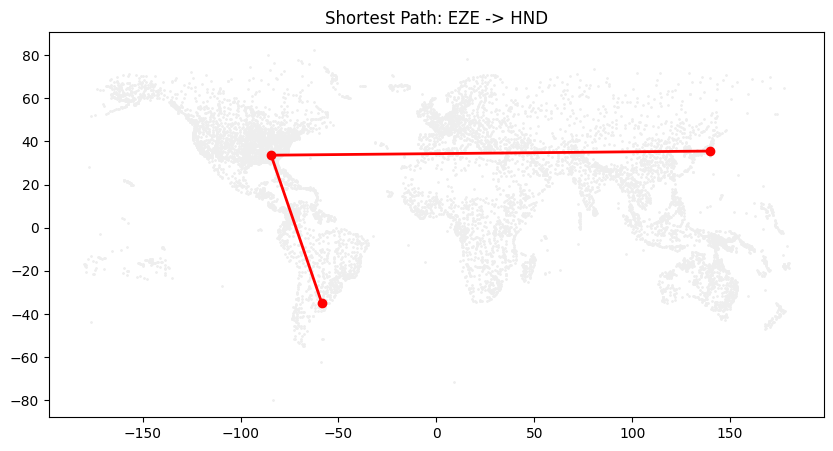

In [11]:
def find_path(start_code, end_code, G):
    try:
        path = nx.shortest_path(G, start_code, end_code)
        stops = len(path) - 1
        return path, stops
    except nx.NetworkXNoPath:
        return None, -1

# Example: New York (JFK) to Sydney (SYD)
start, end = 'EZE', 'HND'
path, stops = find_path(start, end, G)

print(f"--- Route from {start} to {end} ---")
if path:
    print(f"Stops: {stops}")
    print(f"Path: {' -> '.join(path)}")
    
    # Optional: Plot the path
    path_coords = airports.loc[path][['longitude_deg', 'latitude_deg']].values
    plt.figure(figsize=(10, 5))
    plt.scatter(airports['longitude_deg'], airports['latitude_deg'], c='#eee', s=1) # Background
    plt.plot(path_coords[:,0], path_coords[:,1], 'r-o', linewidth=2)
    plt.title(f"Shortest Path: {start} -> {end}")
    plt.show()
else:
    print("No route found.")

**9. Generic visualization tool**
Flexible tool to visualize just about anaything.


EXAMPLE 4: Star Alliance Major Carriers


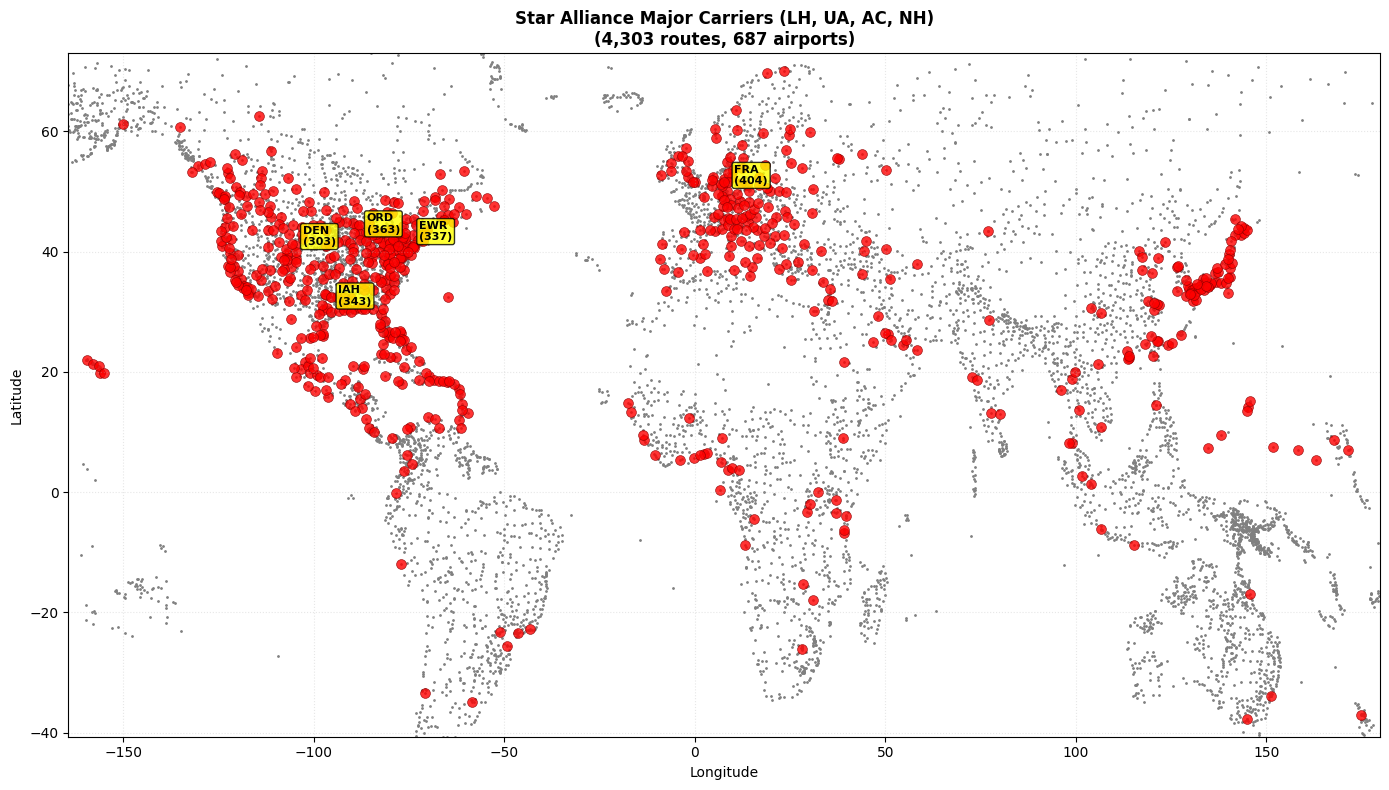


FILTER SUMMARY: Star Alliance Major Carriers (LH, UA, AC, NH)
Total Routes: 4,303
Unique Airports: 687
Unique Source Airports: 677
Unique Destination Airports: 685
Countries (Source): 139
Continents (Source): 6

EXAMPLE 1: Spirit Airlines (NK) Routes


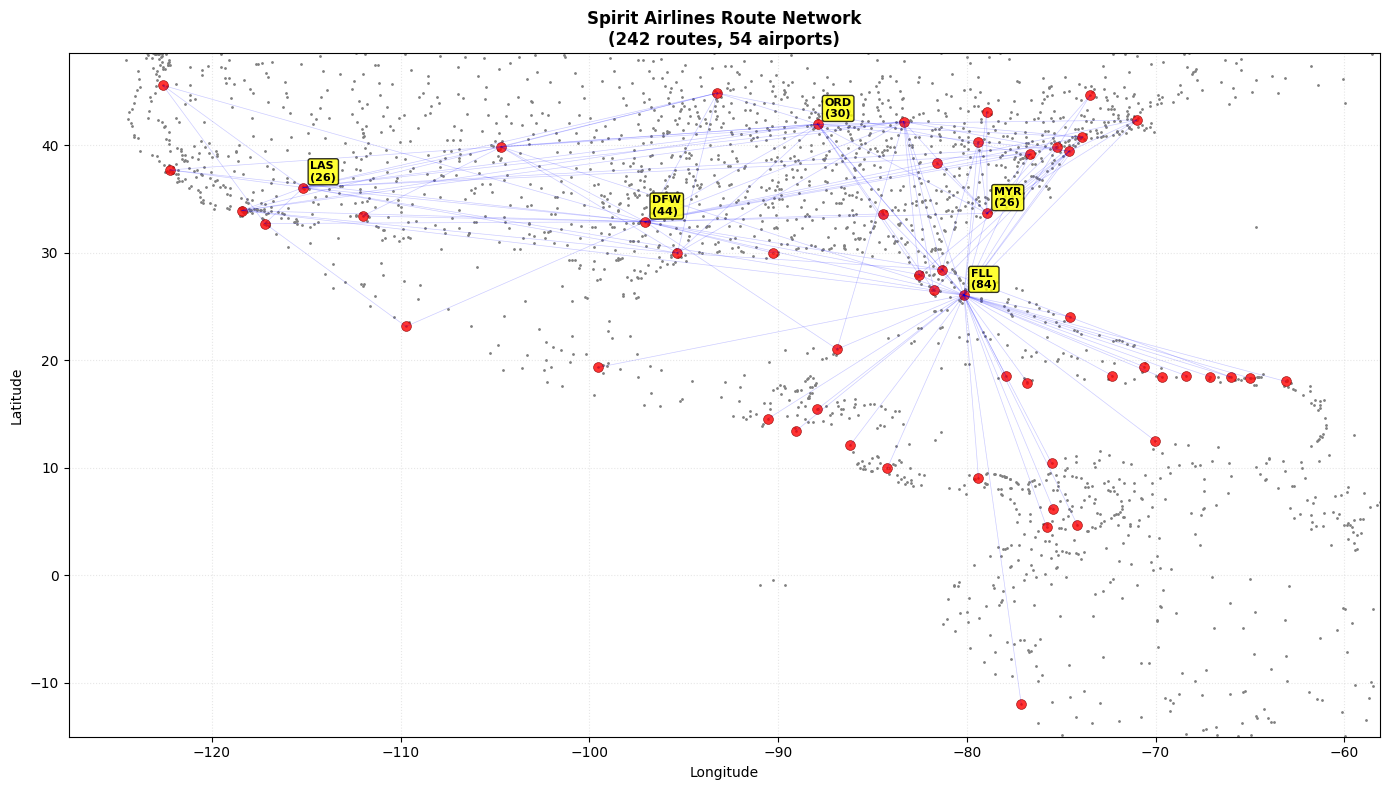


FILTER SUMMARY: Spirit Airlines Route Network
Total Routes: 242
Unique Airports: 54
Unique Source Airports: 54
Unique Destination Airports: 54
Countries (Source): 18
Continents (Source): 2

EXAMPLE 2: All Routes from Austria


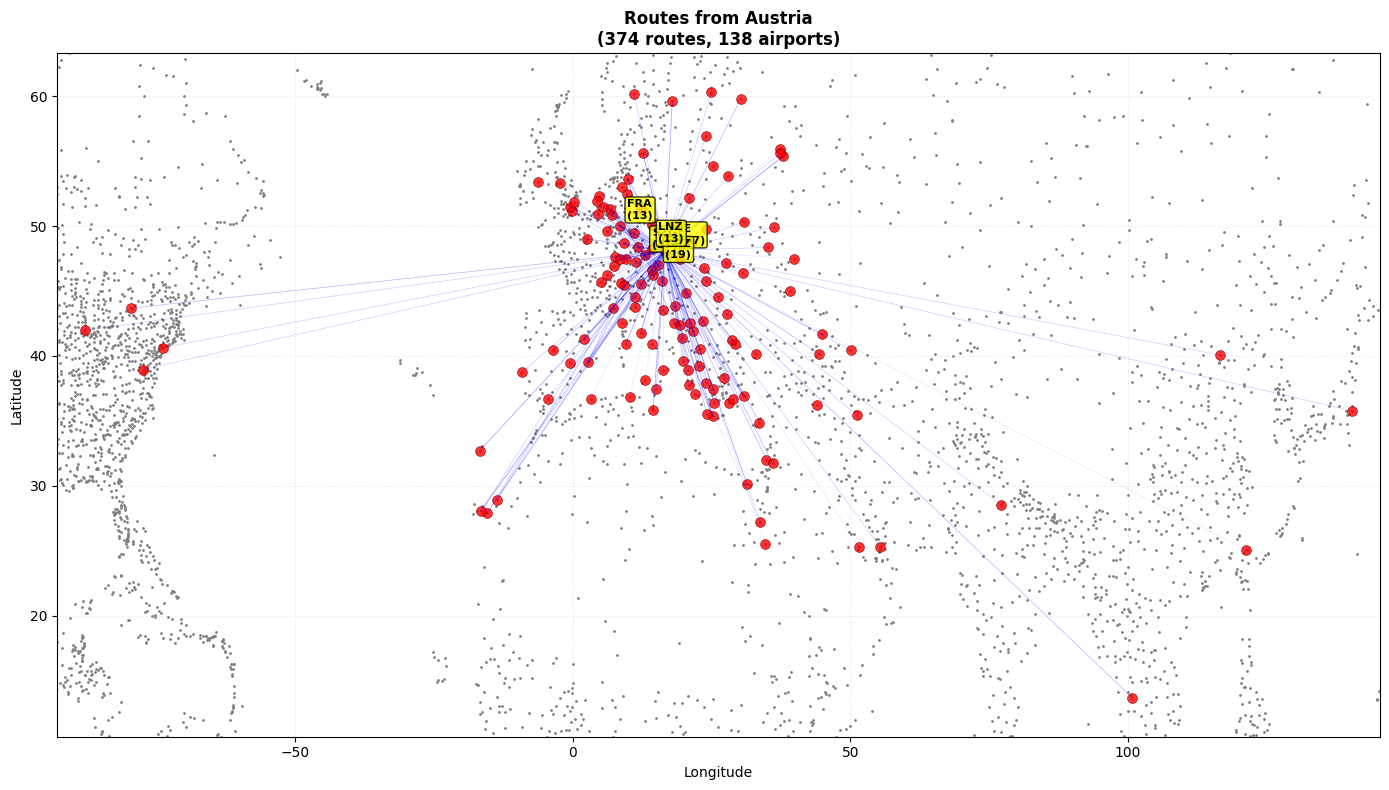


FILTER SUMMARY: Routes from Austria
Total Routes: 374
Unique Airports: 138
Unique Source Airports: 6
Unique Destination Airports: 138
Countries (Source): 1
Continents (Source): 1


(      Airline AirlineID Source SourceID Dest DestID Codeshare  Stops  \
 431        3L      2916    GRZ     1609  ZRH   1678       NaN      0   
 436        3L      2916    SZG     1612  ZRH   1678       NaN      0   
 1490       4U      2548    KLU     4322  CGN    344       NaN      0   
 1491       4U      2548    KLU     4322  HAM    342       NaN      0   
 1636       4U      2548    SZG     1612  CGN    344       NaN      0   
 ...       ...       ...    ...      ...  ...    ...       ...    ...   
 65543      XQ      4573    SZG     1612  AYT   1688       NaN      0   
 65547      XQ      4573    VIE     1613  ADB   1706       NaN      0   
 65548      XQ      4573    VIE     1613  AYT   1688       NaN      0   
 66186      YM      3539    VIE     1613  TGD   1741       NaN      0   
 66335      Z6     16120    VIE     1613  DNK   2941         Y      0   
 
       Equipment src_country src_continent dst_country dst_continent  
 431         DH3          AT            EU         

In [12]:
def visualize_filtered_data(filter_func=None, filter_column=None, filter_value=None,
                            routes_df=None, airports_df=None, G=None,
                            title=None, show_routes=True, color_by=None):
    """
    Generic visualization function for any subset of the dataset.
    
    Parameters:
    -----------
    filter_func : callable, optional
        Custom filter function that takes a DataFrame and returns filtered DataFrame
    filter_column : str, optional
        Column name to filter on (e.g., 'Airline', 'src_country')
    filter_value : str/list, optional
        Value(s) to filter for in filter_column
    routes_df : DataFrame
        Routes dataframe (uses global routes_merged if None)
    airports_df : DataFrame
        Airports dataframe (uses global airports if None)
    G : networkx.Graph
        Network graph (uses global G_global if None)
    title : str, optional
        Custom title for the plot
    show_routes : bool
        Whether to draw route lines
    color_by : str, optional
        Column to color points by (e.g., 'continent', 'iso_country')
    
    Examples:
    ---------
    # All flights by an airline
    visualize_filtered_data(filter_column='Airline', filter_value='BA')
    
    # All flights from a country
    visualize_filtered_data(filter_column='src_country', filter_value='US')
    
    # Custom filter
    visualize_filtered_data(filter_func=lambda df: df[df['src_continent'] == 'EU'])
    
    # Multiple values
    visualize_filtered_data(filter_column='Airline', filter_value=['BA', 'LH', 'AF'])
    """
    # Use globals if not provided
    if routes_df is None:
        routes_df = routes_merged
    if airports_df is None:
        airports_df = airports
    if G is None:
        G = G_global
    
    # Apply filter
    if filter_func is not None:
        filtered_routes = filter_func(routes_df)
    elif filter_column is not None and filter_value is not None:
        if isinstance(filter_value, list):
            filtered_routes = routes_df[routes_df[filter_column].isin(filter_value)]
        else:
            filtered_routes = routes_df[routes_df[filter_column] == filter_value]
    else:
        filtered_routes = routes_df
    
    if len(filtered_routes) == 0:
        print("No data matches the filter criteria!")
        return
    
    # Get unique airports involved
    involved_airports = set(filtered_routes['Source'].unique()) | set(filtered_routes['Dest'].unique())
    filtered_airports = airports_df[airports_df.index.isin(involved_airports)]
    
    # Generate title if not provided
    if title is None:
        if filter_column and filter_value:
            if isinstance(filter_value, list):
                title = f"Routes for {filter_column}: {', '.join(filter_value[:3])}..."
            else:
                title = f"Routes for {filter_column}: {filter_value}"
        else:
            title = "Filtered Route Visualization"
    
    # Calculate bounds
    if len(filtered_airports) > 0:
        lon_min = filtered_airports['longitude_deg'].min() - 5
        lon_max = filtered_airports['longitude_deg'].max() + 5
        lat_min = filtered_airports['latitude_deg'].min() - 3
        lat_max = filtered_airports['latitude_deg'].max() + 3
    else:
        lon_min, lon_max, lat_min, lat_max = -180, 180, -90, 90
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Background: all airports
    ax.scatter(airports_df['longitude_deg'], airports_df['latitude_deg'],
               c='gray', s=1, alpha=1, label='All Airports')
    
    # Draw routes if requested
    if show_routes and len(filtered_routes) <= 2000:  # Limit for performance
        route_sample = filtered_routes.sample(min(500, len(filtered_routes)), random_state=42)
        
        for _, row in route_sample.iterrows():
            try:
                src = airports_df.loc[row['Source']]
                dst = airports_df.loc[row['Dest']]
                ax.plot([src['longitude_deg'], dst['longitude_deg']],
                        [src['latitude_deg'], dst['latitude_deg']],
                        'b-', alpha=0.1, linewidth=0.5)
            except KeyError:
                continue
    
    # Plot filtered airports
    if color_by and color_by in filtered_airports.columns:
        # Color by category
        categories = filtered_airports[color_by].astype('category')
        scatter = ax.scatter(filtered_airports['longitude_deg'], filtered_airports['latitude_deg'],
                             c=categories.cat.codes, cmap='tab10', s=50, alpha=0.8,
                             edgecolors='black', linewidths=0.5)
        
        # Create legend for categories
        unique_cats = categories.cat.categories[:10]  # Limit legend items
        handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), s=50, label=cat) 
                   for i, cat in enumerate(unique_cats)]
        ax.legend(handles=handles, title=color_by, loc='lower left', fontsize=8)
    else:
        ax.scatter(filtered_airports['longitude_deg'], filtered_airports['latitude_deg'],
                   c='red', s=50, alpha=0.8, edgecolors='darkred', linewidths=0.5)
    
    # Annotate major hubs in filtered data
    if len(filtered_routes) > 0:
        hub_counts = pd.concat([
            filtered_routes['Source'].value_counts(),
            filtered_routes['Dest'].value_counts()
        ]).groupby(level=0).sum().sort_values(ascending=False)
        
        top_hubs = hub_counts.head(5)
        for code, count in top_hubs.items():
            if code in filtered_airports.index:
                row = filtered_airports.loc[code]
                ax.annotate(f"{code}\n({count})", 
                            xy=(row['longitude_deg'], row['latitude_deg']),
                            xytext=(5, 5), textcoords='offset points',
                            fontsize=8, fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow', alpha=0.8))
    
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.set_title(f"{title}\n({len(filtered_routes):,} routes, {len(filtered_airports):,} airports)",
                 fontsize=12, fontweight='bold')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True, alpha=0.3, linestyle=':')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'=' * 60}")
    print(f"FILTER SUMMARY: {title}")
    print(f"{'=' * 60}")
    print(f"Total Routes: {len(filtered_routes):,}")
    print(f"Unique Airports: {len(filtered_airports)}")
    print(f"Unique Source Airports: {filtered_routes['Source'].nunique()}")
    print(f"Unique Destination Airports: {filtered_routes['Dest'].nunique()}")
    
    if 'src_country' in filtered_routes.columns:
        print(f"Countries (Source): {filtered_routes['src_country'].nunique()}")
    if 'src_continent' in filtered_routes.columns:
        print(f"Continents (Source): {filtered_routes['src_continent'].nunique()}")
    
    return filtered_routes, filtered_airports

# --- Example Usage ---


#Star alliance
print("\n" + "=" * 80)
print("EXAMPLE 4: Star Alliance Major Carriers")
print("=" * 80)
visualize_filtered_data(filter_column='Airline', filter_value=['LH', 'UA', 'AC', 'NH'],
                        title="Star Alliance Major Carriers (LH, UA, AC, NH)")

#Spirit
print("\n" + "=" * 80)
print("EXAMPLE 1: Spirit Airlines (NK) Routes")
print("=" * 80)
visualize_filtered_data(
    filter_column='Airline',
    filter_value='NK',
    title="Spirit Airlines Route Network"
)

#Austria
print("\n" + "=" * 80)
print("EXAMPLE 2: All Routes from Austria")
print("=" * 80)
visualize_filtered_data(filter_column='src_country', filter_value='AT',
                        title="Routes from Austria", color_by='dst_continent')



